
### 1. Importing data


In [1]:
#importing all the important libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math

In [2]:
#applying transformation to input image along with defining batch size
transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
Batch_Size = 64

In [3]:
#loading the training and testing MNIST data set
train_data = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Batch_Size,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Batch_Size,shuffle=True)

100%|██████████| 170498071/170498071 [00:06<00:00, 26586543.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



### 2. View data


In [4]:
#printing output class of data
classes=train_data.classes
print(classes)
print(train_data.class_to_idx)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}



### 3. View pictures


In [5]:
#defining a function to show images
def show_data(img):
    #as we have transformed image using normalisation so it will detransform it
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

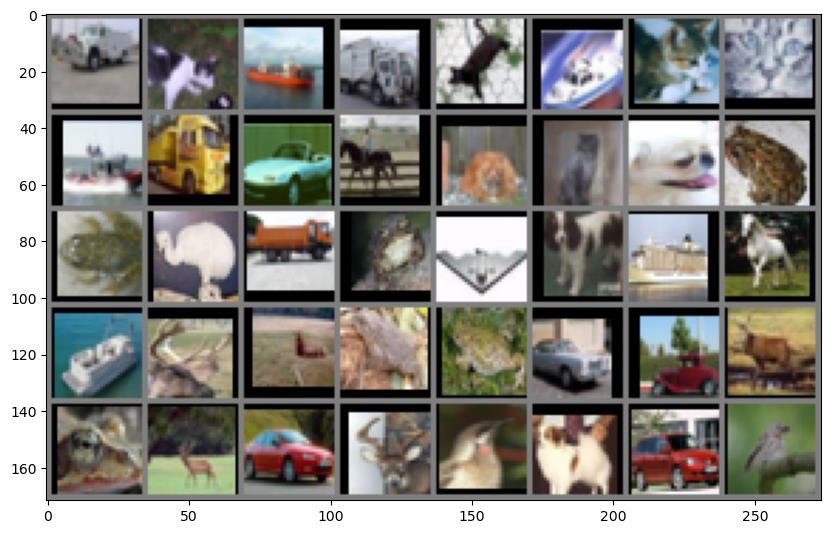

In [6]:
#showing total 40 pictures in grid
im,label = next(iter(train_dataloader))
plt.figure(figsize=(10,12))
show_data(torchvision.utils.make_grid(im[:40]))


### 4. Definition Network DenseNet


In [7]:
#setting the device to cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out

In [9]:
class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [10]:
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [11]:
#DenseNet121 configuration for all its structure
def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)

In [12]:
#Defining the DenseNet-121 of original model
net = DenseNet121()
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark=True


### 5. Define the loss function and optimizer


In [13]:
#optimizer and scheduler for original DenseNet-121 net
optimizer_sgd= optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd, 'min', factor=0.5,patience = 5,min_lr = 0.000001) 
epochs = 40


### 6. Training


In [14]:
#creating the path to save the model
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/DenseNet121.pth'

In [15]:
# function for model training and recording its loss and accuracy
def train(model, trainloader, optimizer, criterion,scheduler):
    #training the model
    model.train()
    #initializing the loss and accuracy as 0
    training_loss = 0.0
    training_acc = 0
    count = 0
    #iterating through the training data
    for i, data in enumerate(trainloader):
        total=len(trainloader)
        count += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        #clearing previous gradient
        optimizer.zero_grad()
        #clearing cuda cache to free memory
        if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
        # forward pass
        outputs = model(image)
        # calculating the loss
        loss = criterion(outputs, labels)
        #backward pass
        loss.backward()
        #optimization setp to update parameter
        optimizer.step()

        #calculating the loss
        training_loss += loss.item()
        # calculating the accuracy
        _, preds = torch.max(outputs.data, 1)
        training_acc += (preds == labels).sum().item()

        #printing the progress of training per epoch
        rate = (i + 1) / total
        a = "*" * int(rate * 50)
        b = "." * (50 - int(rate * 50))
        print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,total,int(rate*100),a,b),end='')

    #claculating the loss and accuracy over all batches
    epoch_loss = training_loss / count
    epoch_acc = 100. * (training_acc / len(trainloader.dataset))
    #stepping the scheduler based on loss per epoch
    scheduler.step(epoch_loss)
    
    # Logging the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    return epoch_loss, epoch_acc,current_lr

In [16]:
#this is the code for model validation
def validate(model, testloader, criterion):
    #setting the model on validating mode
    model.eval()
    #making a list to calculate accuracy for each model
    accurate_class = list(0. for i in range(10))
    total_class = list(0. for i in range(10))

    #initializing validation loss and accuracy
    validation_loss = 0.0
    validation_accuracy = 0
    count = 0

    #disabling gradient computation for validation
    with torch.no_grad():
        for i, data in enumerate(testloader):
            total=len(testloader)
            count += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
            # forward pass
            outputs = model(image)
            # calculating the loss
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            # calculating  the accuracy
            _, preds = torch.max(outputs.data, 1)
            validation_accuracy += (preds == labels).sum().item()
            # calculating the accuracy for each class
            correct  = (preds == labels).squeeze()

            #printing per epoch to track
            rate = (i + 1) / total
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r test {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,total,int(rate*100),a,b),end='')
            
            for i in range(len(preds)):
                label = labels[i]
                accurate_class[label] += correct[i].item()
                total_class[label] += 1
    epoch_loss = validation_loss / count
    epoch_acc = 100. * (validation_accuracy / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [17]:
#This is for training and validating the model calling required functions per epochs
def train_validate(model,optimizer,scheduler):
    #initializing empty list for loss and accuracy
    training_loss, validation_loss = [], []
    training_acc, validation_acc = [], []
    #calculating the total time
    time_taken = time.time()
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        #calculating the time per epoch 
        start_time=time.time()

        #training the model
        train_epoch_loss, train_epoch_acc,lr = train(model, train_dataloader, optimizer, criterion,scheduler)
        #validating the model
        valid_epoch_loss, valid_epoch_acc = validate(model, test_dataloader,  criterion)
        #updating the loss and accuracy list
        training_loss.append(train_epoch_loss)
        validation_loss.append(valid_epoch_loss)
        training_acc.append(train_epoch_acc)
        validation_acc.append(valid_epoch_acc)
        #calculating the end time per epoch
        total_time=time.time()-start_time
        #printing details per epoch
        total_time= time.strftime('%H:%M:%S', time.gmtime(total_time))
        print(f"\rTraining loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}, Learning rate: {lr} Time: {total_time}")

        print('-'*50)
        
    total_time_taken= time.strftime('%H:%M:%S', time.gmtime(time.time()-time_taken))
    print(f"\nFinal time taken to run total is::{total_time_taken}")
    return training_loss, validation_loss, training_acc, validation_acc

In [18]:
def plot_loss_Acc(training_loss, validation_loss, training_acc, validation_acc):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Plot accuracy in the first subplot
    ax1.plot(training_acc, color='green', linestyle='-', label='train accuracy')
    ax1.plot(validation_acc, color='blue', linestyle='-', label='validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.set_title('Accuracy Over Epochs')

    # Plot loss in the second subplot
    ax2.plot(training_loss, color='orange', linestyle='-', label='train loss')
    ax2.plot(validation_loss, color='red', linestyle='-', label='validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.set_title('Loss Over Epochs')

    # Show the plots
    plt.tight_layout()
    plt.show()
    print(f"\nTraining loss::{training_loss}")
    print(f"\nValidation loss::{validation_loss}")
    print(f"\nTraining Accuracy::{training_acc}")
    print(f"\nValidation Accuracy::{validation_acc}")

In [19]:
def test_model(model):
    correct = 0
    total = 0
    class_correct = list(0.for i in range(10))
    class_total = list(0.for i in range(10))
    model.eval()
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = model(images) 
    
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [20]:
#this is for printing the correct and predicted label of model
def print_image(model):
    # Getting one batch of test images and labels
    dataiter = iter(test_dataloader)
    images, labels = next(dataiter)
    images_ = images
    images_ = images_.to(device)
    labels = labels.to(device)
    # Computing the model's output (predictions)
    val_output = model(images_)
    _, val_preds = torch.max(val_output, 1)

    fig = plt.figure(figsize=(25,4))

    # Calculating and print the accuracy for this batch
    correct = torch.sum(val_preds == labels.data).item()

    val_preds = val_preds.cpu()
    labels = labels.cpu()
    
    print("Accuracy Rate per batch = {}%".format(correct/len(images) * 100))

    #displaying predicted and corrected label
    fig = plt.figure(figsize=(25,25))
    for idx in np.arange(32):    
        ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
        show_data(images[idx])
        ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

    #printing the confusion matrix for this batch
    conf_matrix = confusion_matrix(labels, val_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

[INFO]: Epoch 1 of 40


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Training loss: 1.697, training acc: 37.754, Validation loss: 1.449, validation acc: 47.440, Learning rate: 0.001 Time: 00:01:38
--------------------------------------------------
[INFO]: Epoch 2 of 40
Training loss: 1.265, training acc: 54.432, Validation loss: 1.160, validation acc: 58.660, Learning rate: 0.001 Time: 00:02:02
--------------------------------------------------
[INFO]: Epoch 3 of 40
Training loss: 1.040, training acc: 63.006, Validation loss: 0.936, validation acc: 66.910, Learning rate: 0.001 Time: 00:02:00
--------------------------------------------------
[INFO]: Epoch 4 of 40
Training loss: 0.903, training acc: 68.070, Validation loss: 0.871, validation acc: 69.160, Learning rate: 0.001 Time: 00:01:59
--------------------------------------------------
[INFO]: Epoch 5 of 40
Training loss: 0.796, training acc: 71.970, Validation loss: 0.782, validation acc: 72.860, Learning rate: 0.001 Time: 00:02:00
--------------------------------------------------
[INFO]: Epoch 6 o

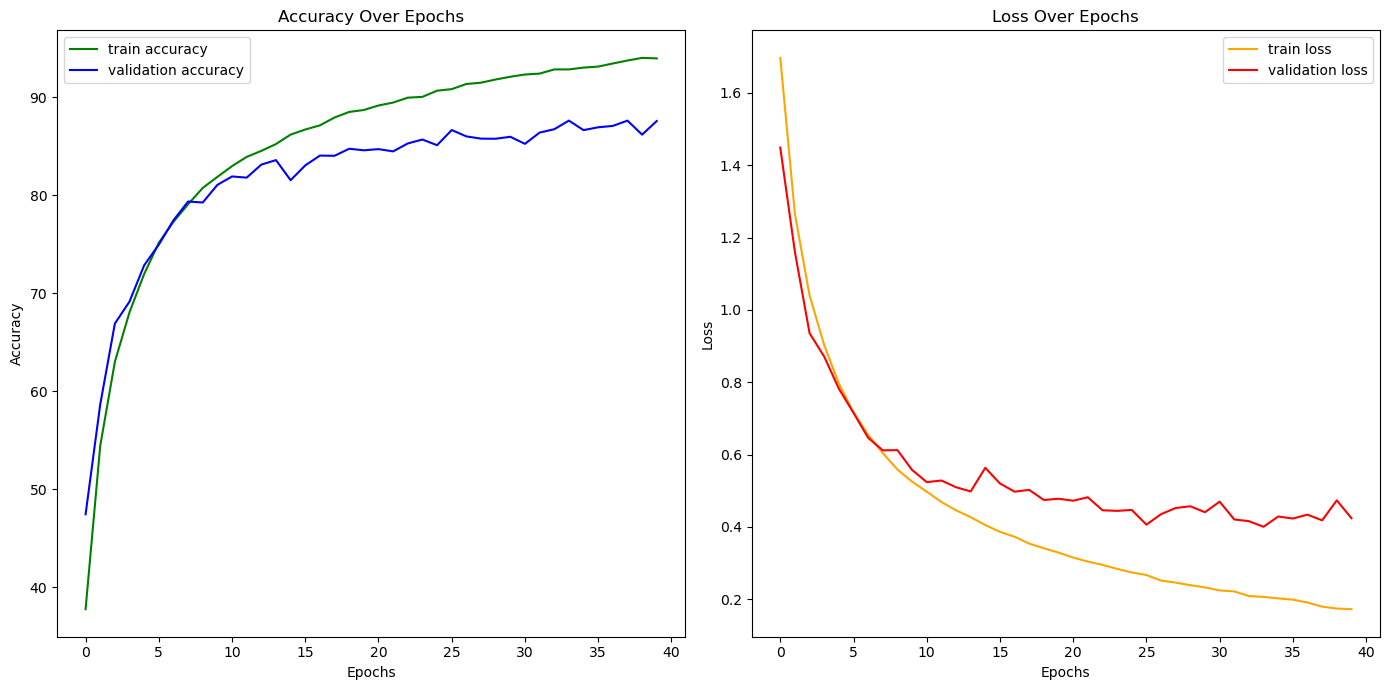


Training loss::[1.696927690749888, 1.2651471377486159, 1.04020106007376, 0.9029246828592646, 0.7963765996801274, 0.716916482085767, 0.6544700368590977, 0.6041809384856383, 0.558882695177327, 0.5251205707983593, 0.4974901754494823, 0.4689178524343559, 0.44597933845370624, 0.4269052870438227, 0.4052129436827377, 0.38643428050648526, 0.37299046938872094, 0.3538151588814948, 0.34104320061062, 0.3289400988622852, 0.3153300177486961, 0.3043020511584361, 0.2952231493161615, 0.2840686309653932, 0.27421721379699, 0.26714701332209057, 0.2517058220227509, 0.24607890436563956, 0.2389667329361753, 0.2329183868597002, 0.22447206518229315, 0.22174531599158978, 0.2089169808208485, 0.2066586062054881, 0.20247377493821295, 0.19898231680531178, 0.19100697799716765, 0.1795882590429481, 0.1744190672688815, 0.1726671853257567]

Validation loss::[1.448907339648836, 1.1600249022435232, 0.9357886462454583, 0.8710071121811107, 0.7823471178294746, 0.7155494441272346, 0.6464261797962675, 0.6117765666193263, 0.61

<Figure size 2500x400 with 0 Axes>

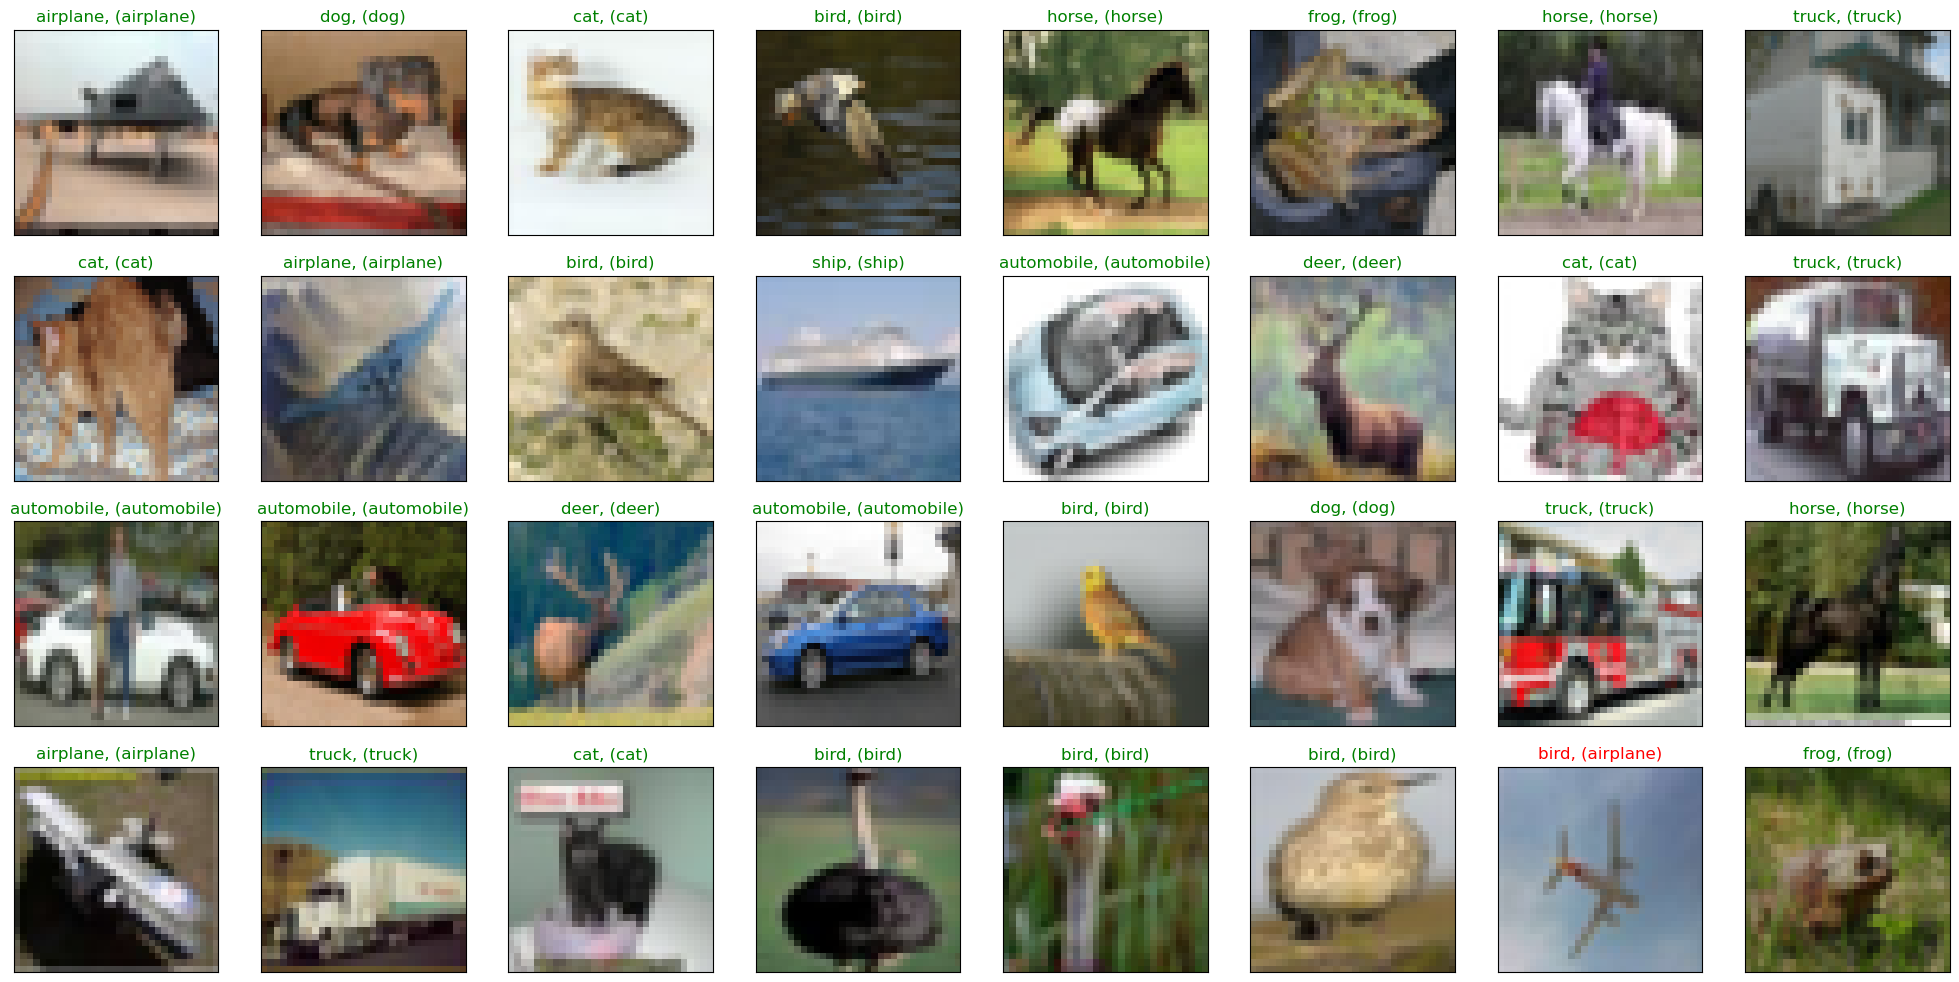

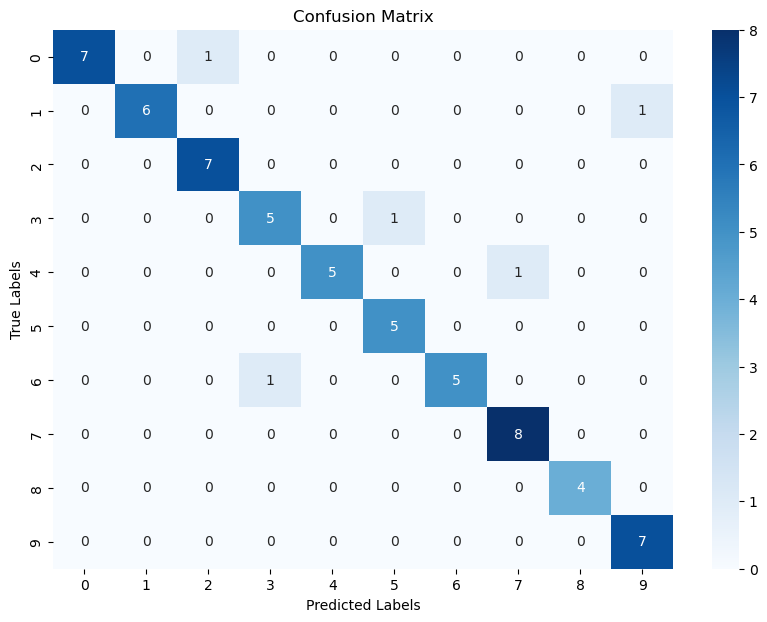

In [21]:
training_loss, validation_loss, training_acc, validation_acc= train_validate(net,optimizer_sgd,scheduler_sgd)
print("\n")
plot_loss_Acc(training_loss, validation_loss, training_acc, validation_acc)
print("\n")
test_model(net)
print("\n")
print_image(net)


### 8. Save the model


In [23]:
torch.save(net,save_path[:-4]+str(epochs+1)+'.pth')